In [2]:
!pip install pot

import h5py
import openslide
import torch
import pandas as pd
from prototype_visualization_utils import get_panther_encoder, visualize_categorical_heatmap, get_mixture_plot, get_default_cmap
import sys
sys.path.append('../')
from mil_models.tokenizer import PrototypeTokenizer


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:

import h5py

# Open the HDF5 file
file_path = 'results/mutation::PANTHER_default::vit_large_patch16_224.dinov2.uni_mass100k/mutation/k=0/temporary::PANTHER_default+LinearEmb::cox::feats_pt/temporary::PANTHER_default+LinearEmb::cox::feats_pt::24-09-21-21-09-22/all_dumps.h5'
with h5py.File(file_path, 'r') as f:
    # List all groups and datasets in the file
    print("Keys in the file:", list(f.keys()))

    # Access specific datasets
    dataset_name = 'your_dataset_name'  # Replace with a valid dataset name from the keys
    data = f[dataset_name][:]
    
    # Display



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


OSError: Unable to open file (file signature not found)

In [36]:
### Loading PANTHER Encoder
#temporary/nadieh/PANTHER/src/visualization/prototypical_assignment_map_visualization.ipynb

proto_path = 'results/mutation::PANTHER_default::vit_large_patch16_224.dinov2.uni_mass100k/mutation/k=0/temporary::PANTHER_default+LinearEmb::cox::feats_pt/temporary::PANTHER_default+LinearEmb::cox::feats_pt::24-09-21-21-09-22/test_results.pkl'
panther_encoder = get_panther_encoder(in_dim=1024, p=16, proto_path=proto_path, config_dir='configs/')

results/mutation::PANTHER_default::vit_large_patch16_224.dinov2.uni_mass100k/mutation/k=0/temporary::PANTHER_default+LinearEmb::cox::feats_pt/temporary::PANTHER_default+LinearEmb::cox::feats_pt::24-09-21-21-09-22/test_results.pkl
jlsjdkjdsl


KeyError: 'prototypes'

In [30]:
proto_path = 'results/mutation::PANTHER_default::vit_large_patch16_224.dinov2.uni_mass100k/mutation/k=0/temporary::PANTHER_default+LinearEmb::cox::feats_pt/temporary::PANTHER_default+LinearEmb::cox::feats_pt::24-09-21-21-09-22/test_results.pkl'

In [31]:
proto_path.endswith('pkl')

True

In [33]:
### open your WSI and features
slide_id = 'TCGA-AR-A1AQ-01Z-00-DX1.09D5D7FC-0FA8-4176-94B2-995F44D8ED4C'
slide_fpath = f'path/to/tcga_lung/{slide_id}.svs'
h5_feats_fpath = f'path/to/tcga_lung_feats/{slide_id}.h5'

wsi = openslide.open_slide(slide_fpath)
h5 = h5py.File(h5_feats_fpath, 'r')

coords = h5['coords'][:]
feats = torch.Tensor(h5['features'][:])
patch_size = h5['coords'].attrs['patch_size']

### get PANTHER representation and GMM mixtures
with torch.inference_mode():
    info = panther_encoder.representation(feats.unsqueeze(dim=0))
    qqs = info['qq']
    out = info['repr']
    tokenizer = PrototypeTokenizer(p=16)
    mus, pis, sigmas = tokenizer.forward(out)
    mus = mus[0].detach().cpu().numpy()
    qq = qqs[0,:,:,0].cpu().numpy()
    global_cluster_labels = qq.argmax(axis=1)

### Visualize the categorical heatmap and the GMM mixtures
cat_map = visualize_categorical_heatmap(
    wsi,
    coords, 
    global_cluster_labels, 
    label2color_dict=get_default_cmap(16),
    vis_level=wsi.get_best_level_for_downsample(128),
    patch_size=(patch_size, patch_size),
    alpha=0.4,
)

display(cat_map.resize((cat_map.width//4, cat_map.height//4)))
display(get_mixture_plot(mus))

FileNotFoundError: [Errno 2] No such file or directory: 'path/to/tcga_lung/TCGA-AR-A1AQ-01Z-00-DX1.09D5D7FC-0FA8-4176-94B2-995F44D8ED4C.svs'

### Additional Examples of Prototypical Assignment Maps
- Shown below are additional examples of prototypical assignment maps in the test set of the NSCLC subtyping task. We show both exemplar and failure cases in PANTHER. Within `./tcga_lung_categorical_maps.zip` are visualizations for all test TCGA WSIs in the NSCLC subtyping task.
- **Limitations**: As unsupervised slide representations in PANTHER are created using non-parametric techniques such as K-Means Clustering and GMMs (which rely on Euclidean distance or dot product to compare embeddings), dependent on the severity of distribution shift between the train and test distributions (due to variable H&E stain variability), prototype assignment for certain WSIs may lead to results in which all patches are assigned to a single prototype. This is exemplified in TCGA which has site-specific biases, and is thus an important consideration when considering using PANTHER (or any non-parametric approach) for morphological feature discovery. Additionally, when clustering over a WSI dataset composed of millions to billions of patches, wclustering with only C=16 clusters will likely underfit the dataset, and also lead to collapse of all patches in a WSI falling under a single prototype.

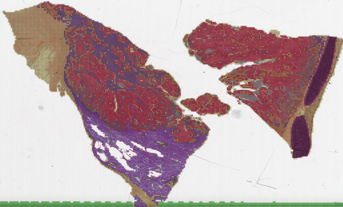

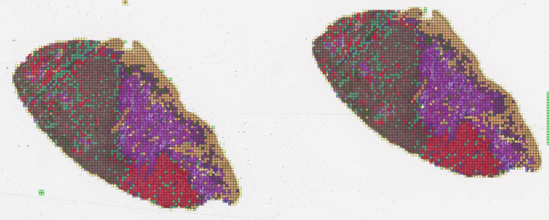

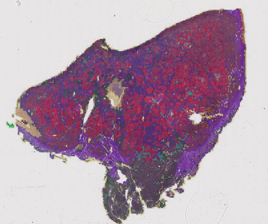

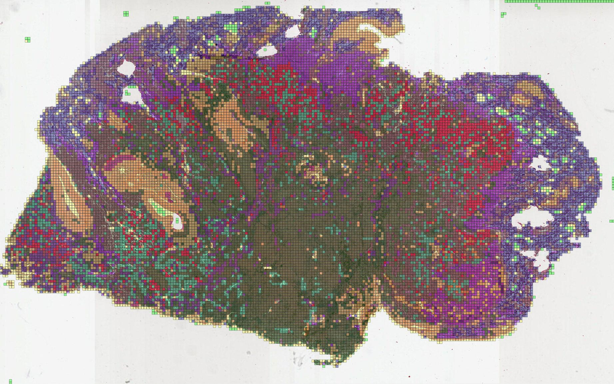

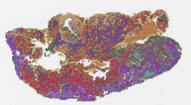

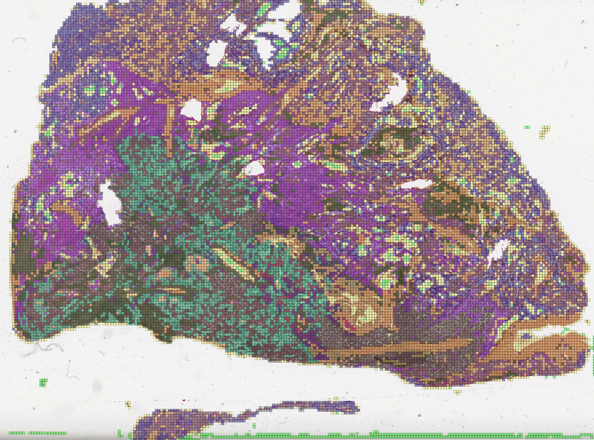

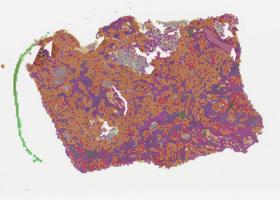

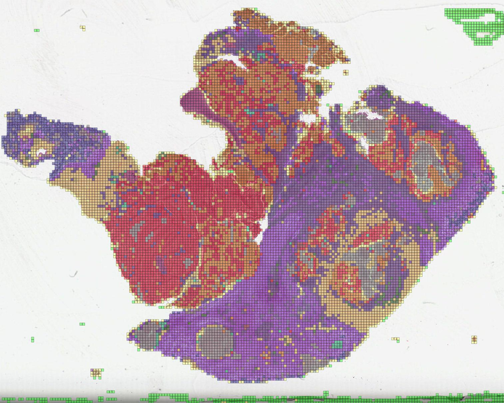

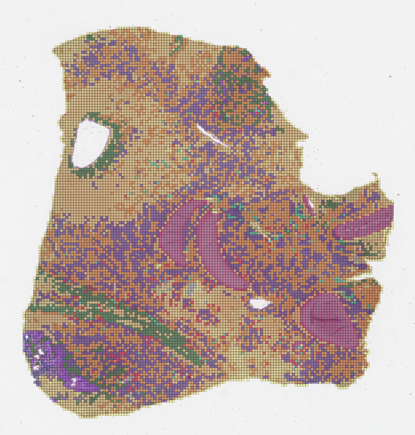

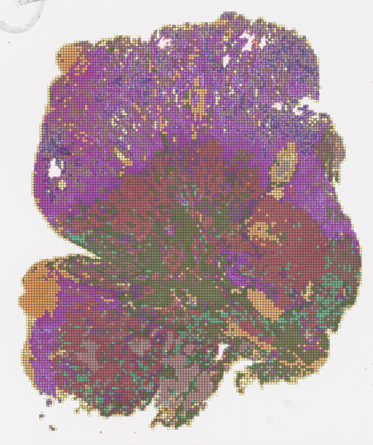

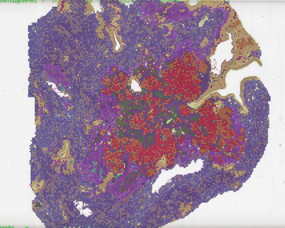

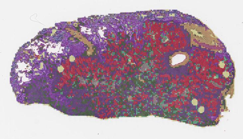

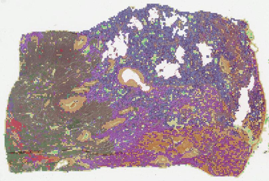

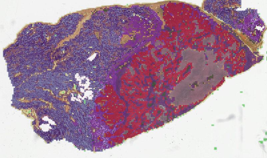

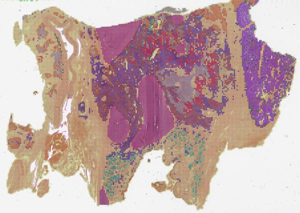

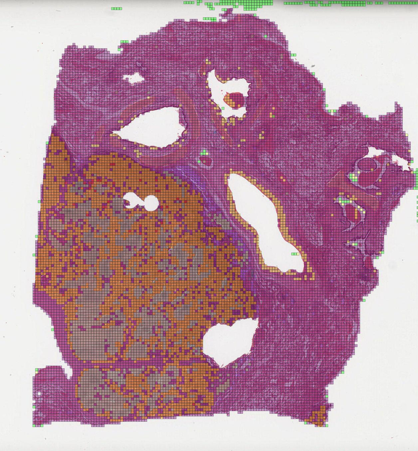

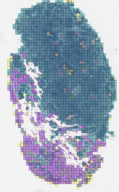

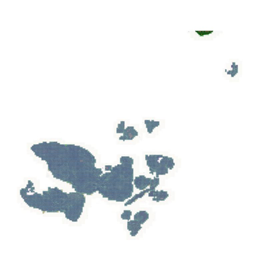